In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from config import setup_wandb_dedicated, setup_wandb_parametrized
from models import MyModel, createSimpleModel

In [16]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

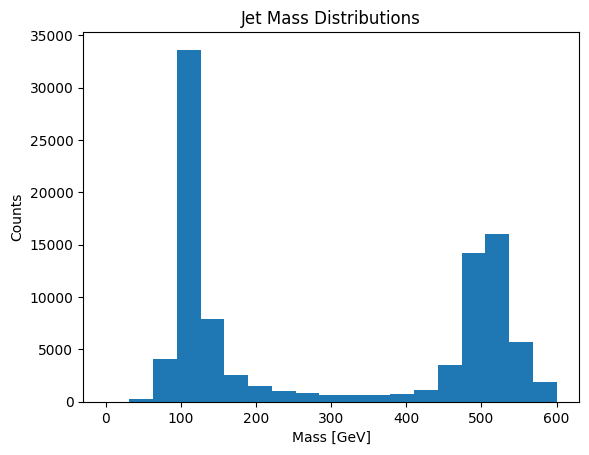

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [21]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [22]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [23]:
np.shape(x[0,0])

(120930, 4)

In [1035]:
x = {}
x_array_read = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [24]:
np.shape(x[0,0])

(120930, 4)

In [25]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dedicated.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


In [126]:
#if not wandb.run:
    #initializies wandb config
wandb.init(
    project="Anomaly",
    group="Dedicated2",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        # "dropout_1": 0.5,
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "BCE",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [27]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

In [28]:
myhistory = model_dedicated.fit(x_vals_100, y_vals_100, epochs=20,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/20
 27/193 [===>..........................] - ETA: 0s - loss: 0.4554 - accuracy: 0.8258   

2023-10-16 13:44:12.176633: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


193/193 [==============================] - 5s 3ms/step - loss: 0.2751 - accuracy: 0.8886 - val_loss: 0.2035 - val_accuracy: 0.9182
Epoch 2/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.9251 - val_loss: 0.1840 - val_accuracy: 0.9269
Epoch 3/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9276 - val_loss: 0.1779 - val_accuracy: 0.9290
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9282 - val_loss: 0.1776 - val_accuracy: 0.9285
Epoch 5/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1781 - accuracy: 0.9283 - val_loss: 0.1768 - val_accuracy: 0.9293
Epoch 6/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9285 - val_loss: 0.1762 - val_accuracy: 0.9292
Epoch 7/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9291 - val_loss: 0.1758 - val_accuracy: 0.9294
Epoch 8/20
193/19

In [383]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

Epoch 1/20
184/193 [===========================>..] - ETA: 0s - loss: 0.2578 - accuracy: 0.8942

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.2552 - accuracy: 0.8954 - val_loss: 0.1934 - val_accuracy: 0.9212
Epoch 2/20
184/193 [===========================>..] - ETA: 0s - loss: 0.1912 - accuracy: 0.9239

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1911 - accuracy: 0.9240 - val_loss: 0.1814 - val_accuracy: 0.9268
Epoch 3/20
174/193 [==========================>...] - ETA: 0s - loss: 0.1854 - accuracy: 0.9261

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1854 - accuracy: 0.9260 - val_loss: 0.1794 - val_accuracy: 0.9273
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9268 - val_loss: 0.1800 - val_accuracy: 0.9270
Epoch 5/20
178/193 [==========================>...] - ETA: 0s - loss: 0.1824 - accuracy: 0.9266

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1825 - accuracy: 0.9264 - val_loss: 0.1785 - val_accuracy: 0.9277
Epoch 6/20
186/193 [===========================>..] - ETA: 0s - loss: 0.1816 - accuracy: 0.9269

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1814 - accuracy: 0.9270 - val_loss: 0.1765 - val_accuracy: 0.9281
Epoch 7/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9275 - val_loss: 0.1768 - val_accuracy: 0.9281
Epoch 8/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9274 - val_loss: 0.1782 - val_accuracy: 0.9273
Epoch 9/20
167/193 [========================>.....] - ETA: 0s - loss: 0.1813 - accuracy: 0.9275

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1806 - accuracy: 0.9278 - val_loss: 0.1762 - val_accuracy: 0.9282
Epoch 10/20
165/193 [========================>.....] - ETA: 0s - loss: 0.1799 - accuracy: 0.9279

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


193/193 [==============================] - 11s 59ms/step - loss: 0.1798 - accuracy: 0.9277 - val_loss: 0.1761 - val_accuracy: 0.9287
Epoch 11/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9277 - val_loss: 0.1781 - val_accuracy: 0.9273
Epoch 12/20
166/193 [========================>.....] - ETA: 0s - loss: 0.1788 - accuracy: 0.9281

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9279 - val_loss: 0.1753 - val_accuracy: 0.9284
Epoch 13/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1785 - accuracy: 0.9279 - val_loss: 0.1772 - val_accuracy: 0.9284
Epoch 14/20
170/193 [=========================>....] - ETA: 0s - loss: 0.1789 - accuracy: 0.9282

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1785 - accuracy: 0.9284 - val_loss: 0.1743 - val_accuracy: 0.9285
Epoch 15/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9281 - val_loss: 0.1760 - val_accuracy: 0.9282
Epoch 16/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1782 - accuracy: 0.9283 - val_loss: 0.1756 - val_accuracy: 0.9288
Epoch 17/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1781 - accuracy: 0.9285

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1778 - accuracy: 0.9285 - val_loss: 0.1739 - val_accuracy: 0.9290
Epoch 18/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1740 - val_accuracy: 0.9292
Epoch 19/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1773 - val_accuracy: 0.9278
Epoch 20/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1772 - accuracy: 0.9289 - val_loss: 0.1744 - val_accuracy: 0.9289


In [384]:
wandb.finish()

accuracy,▁▇▇█▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇▇▇▆▇█▆▇▇▇▇███▇█
val_loss,█▄▃▃▃▂▂▃▂▂▂▁▂▁▂▂▁▁▂▁
accuracy,0.92885
best_epoch,16
best_val_loss,0.17393
epoch,19
loss,0.1772
val_accuracy,0.92891


In [385]:
#model.save("model_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_BCE/assets


In [386]:
model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [56]:
test_dict = {} 
test_dict[tuple((0, 0))] = [1, 2]

test_dict[(0,0)]

[1, 2]

In [82]:
preds_mm_list = []
# fpr_mm_list = []
# tpr_mm_list = []

tuple_rates_dedicated = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        print(i, j)
        x_vals_mm = np.concatenate([x[0,0],x[i,j]])
        y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
        X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)
        
        model = Sequential()
        model.add(Dense(128, input_dim=4, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        myhistory = model.fit(x_vals_mm, y_vals_mm, epochs=20,validation_data=(X_val_mm, Y_val_mm),batch_size=1024)
        
        preds_mm = model.predict(X_val_mm,batch_size=1000)
        fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)
        
        preds_mm_list.append(preds_mm)
        # fpr_mm_list.append(fpr_mm)
        # tpr_mm_list.append(tpr_mm)
        tuple_rates_dedicated[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/20
192/192 [==============================] - 1s 3ms/step - loss: 0.3200 - accuracy: 0.8637 - val_loss: 0.2772 - val_accuracy: 0.8823
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2727 - accuracy: 0.8840 - val_loss: 0.2693 - val_accuracy: 0.8857
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2687 - accuracy: 0.8856 - val_loss: 0.2656 - val_accuracy: 0.8867
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2665 - accuracy: 0.8867 - val_loss: 0.2644 - val_accuracy: 0.8877
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2650 - accuracy: 0.8873 - val_loss: 0.2621 - val_accuracy: 0.8884
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.8886 - val_loss: 0.2605 - val_accuracy: 0.8889
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.8892 - val_loss: 0.2571 - val_accuracy: 0.891

In [83]:
len(tuple_rates_dedicated)

144

In [85]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated", tuple_rates_dedicated)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [113]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [130]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 752us/step


In [115]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 743us/step


Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

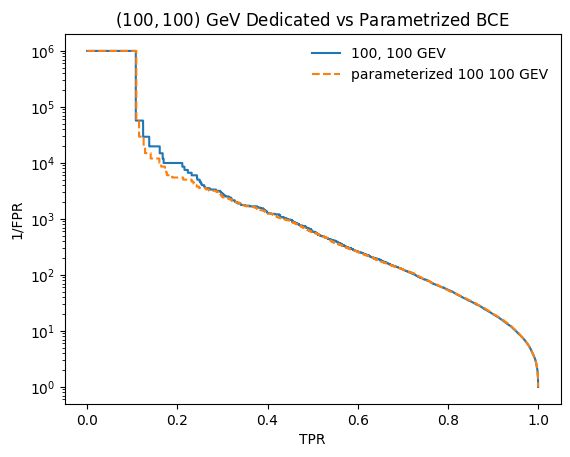

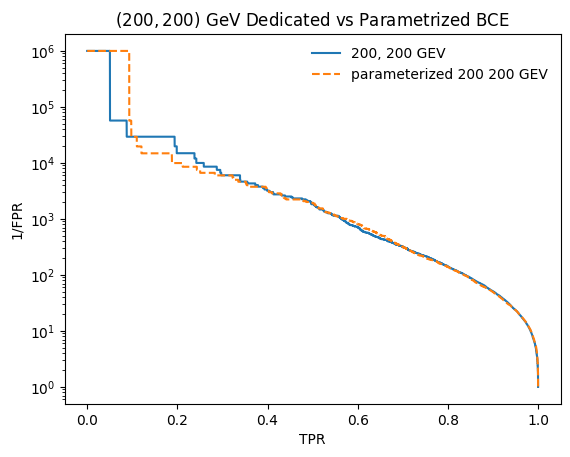

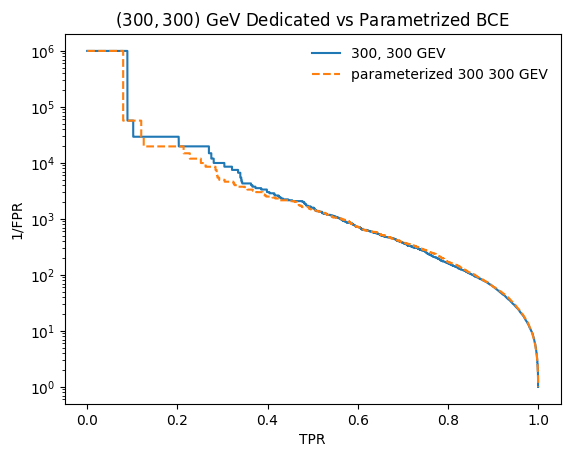

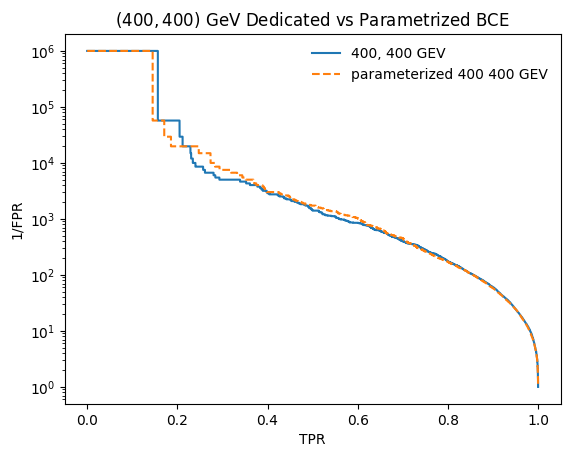

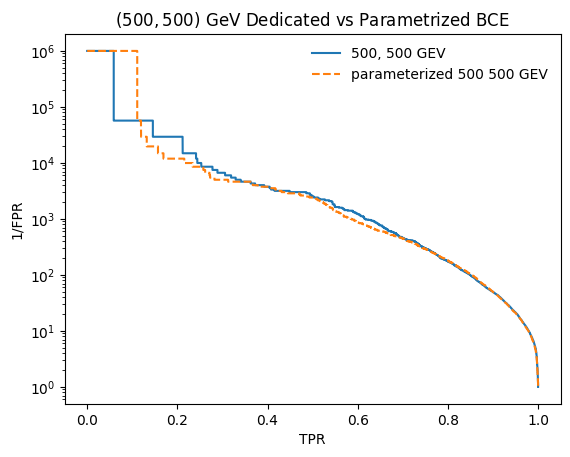

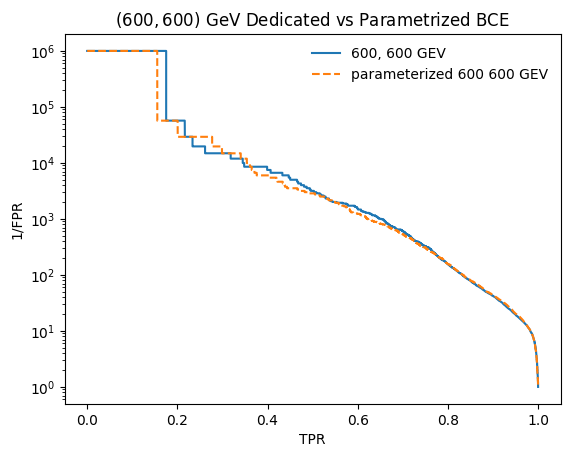

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Text(0.5, 1.0, '$(m_{B},m_{C})$ GeV Dedicated BCE')

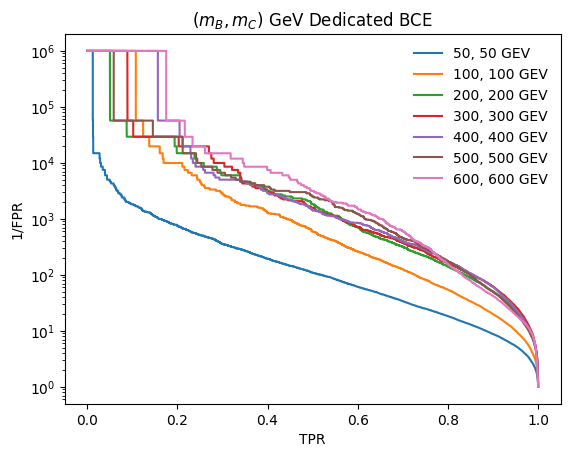

In [120]:
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(0.5,0.5)][1], 1./(tuple_rates_dedicated[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV")
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ GeV Dedicated BCE")

Text(0.5, 1.0, '$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE')

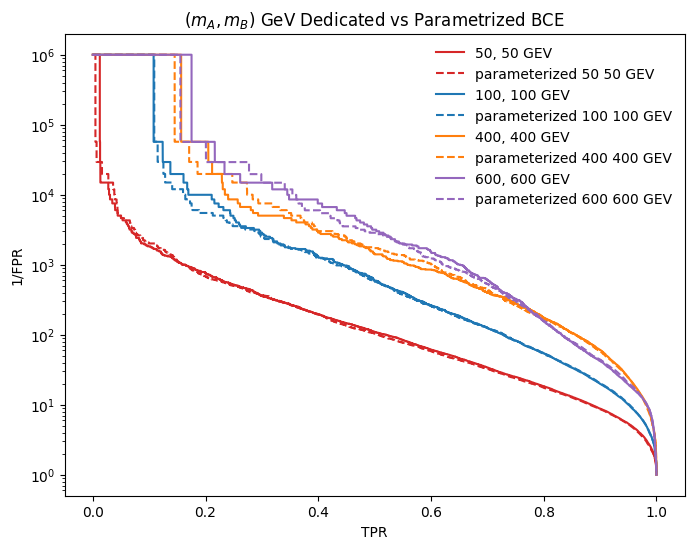

In [132]:
plt.figure(figsize = (8, 6))
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(0.5,0.5)][1], 1./(tuple_rates_dedicated[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV", color = "#d62728")
plt.plot(tpr_all_BCE_50, 1./(fpr_all_BCE_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed', color = "#d62728")

plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV", color = "#1f77b4")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed', color = "#1f77b4")

plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV", color = "#ff7f0e")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed', color = "#ff7f0e")

plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV", color = "#9467bd")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed', color = "#9467bd")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

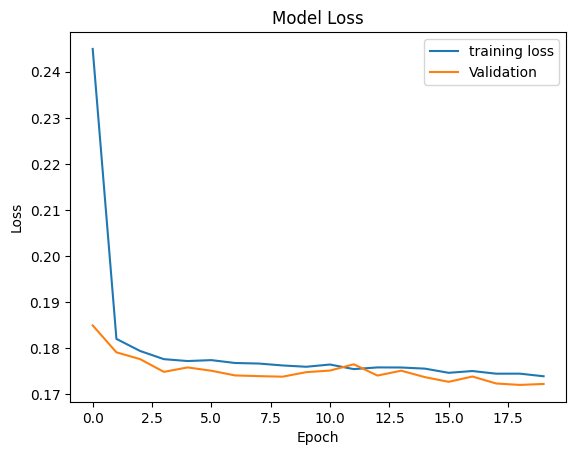

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


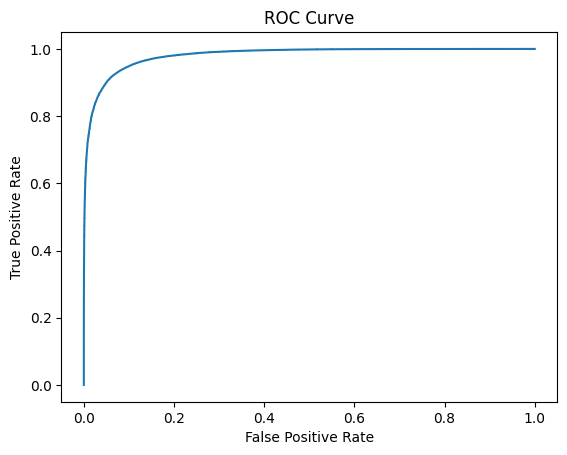

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [833]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [920]:
x_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_vals_qq.npy")
y_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/y_vals_qq.npy")

In [1032]:
np.shape(x_vals_qq)

(27188652, 8)

In [1033]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_vals_qq, y_vals_qq, test_size=0.5)

In [96]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [97]:
np.shape(x_vals_all)

(27188652, 6)

In [835]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [98]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [798]:
wandb.init(
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 1024,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 256,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "MeanSquaredError",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [1034]:
model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(x_vals_qq, y_vals_qq, epochs=20,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024)

Epoch 1/20
5311/5311 [==============================] - 21s 4ms/step - loss: 0.0630 - accuracy: 0.9182 - val_loss: 0.0522 - val_accuracy: 0.9328
Epoch 2/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.0497 - accuracy: 0.9357 - val_loss: 0.0477 - val_accuracy: 0.9381
Epoch 3/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.0464 - accuracy: 0.9394 - val_loss: 0.0451 - val_accuracy: 0.9409
Epoch 4/20
5311/5311 [==============================] - 16s 3ms/step - loss: 0.0444 - accuracy: 0.9417 - val_loss: 0.0435 - val_accuracy: 0.9426
Epoch 5/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.0431 - accuracy: 0.9432 - val_loss: 0.0425 - val_accuracy: 0.9438
Epoch 6/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.0422 - accuracy: 0.9442 - val_loss: 0.0417 - val_accuracy: 0.9447
Epoch 7/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.0415 - accuracy: 0.9450 - val_loss: 0.0411 - val_ac

In [929]:
#model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


In [1031]:
model_qq = tf.keras.models.load_model('model_qq_BCE')

In [99]:
model_all = Sequential()
model_all.add(Dense(128, input_dim=6, activation='relu'))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(1, activation='sigmoid'))
model_all.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [100]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=20,validation_data=(X_val_all, Y_val_all),batch_size=1024*5)

Epoch 1/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.1757 - accuracy: 0.9310 - val_loss: 0.1636 - val_accuracy: 0.9358
Epoch 2/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1630 - accuracy: 0.9360 - val_loss: 0.1625 - val_accuracy: 0.9363
Epoch 3/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1622 - accuracy: 0.9364 - val_loss: 0.1616 - val_accuracy: 0.9367
Epoch 4/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1617 - accuracy: 0.9366 - val_loss: 0.1622 - val_accuracy: 0.9363
Epoch 5/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1614 - accuracy: 0.9367 - val_loss: 0.1610 - val_accuracy: 0.9369
Epoch 6/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1612 - accuracy: 0.9368 - val_loss: 0.1609 - val_accuracy: 0.9369
Epoch 7/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1610 - accuracy: 0.9369 - val_loss: 0.1613 - val_ac

In [789]:
wandb.finish()

accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
accuracy,0.94983
best_epoch,19
best_val_loss,0.12642
epoch,19
loss,0.12954
val_accuracy,0.95101


In [112]:
model_all.save("model_all_BCE")
#model_all.save("model_all_MSE")

INFO:tensorflow:Assets written to: model_all_BCE/assets


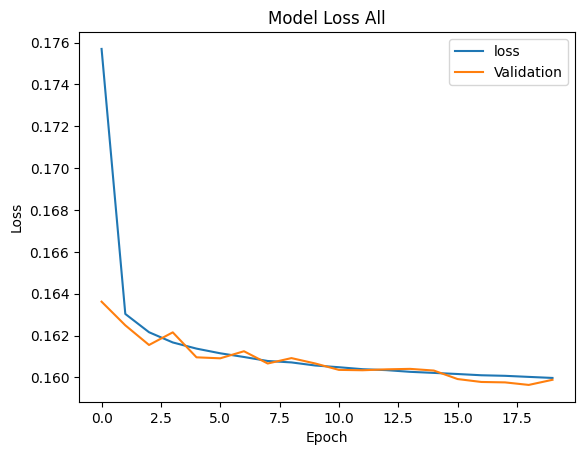

In [101]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [781]:
# preds_all_MSE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
# fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

In [103]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

99/99 [==============================] - 0s 634us/step


In [991]:
#model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [102]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 657us/step


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE')

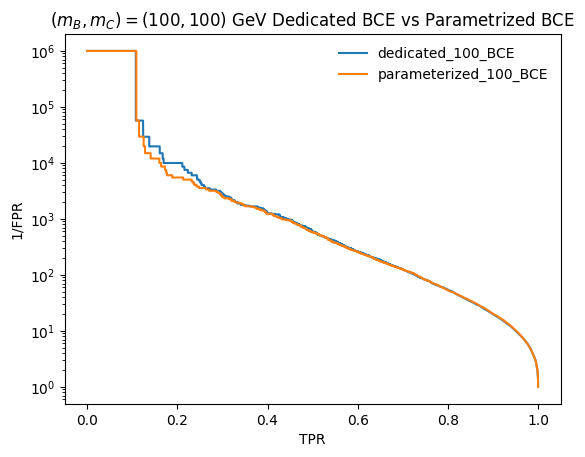

In [108]:
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(1,1)][1],1./(tuple_rates_dedicated[(1,1)][0] + epsilon),label="dedicated_100_BCE")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE + epsilon),label="parameterized_100_BCE")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE")

Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE')

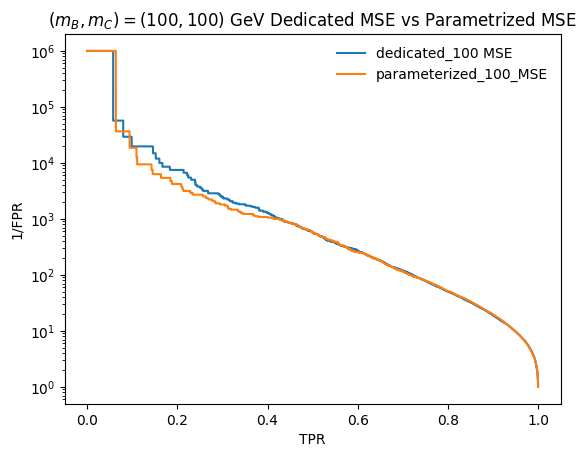

In [455]:
plt.plot(tpr_100_MSE,1./(fpr_100_MSE + epsilon),label="dedicated_100 MSE")
plt.plot(tpr_all_MSE,1./(fpr_all_MSE + epsilon),label="parameterized_100_MSE")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE")

In [423]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [82]:
model_all2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.ones_like_1 (TFOpLambda)    (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['tf.ones_like[0][0]']           
 ingOpLambda)                                                                               

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [1024]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1.)
            model32 = createSimpleModel(4.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 2ms/step - loss: 0.2764 - val_loss: 0.2302
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2185 - val_loss: 0.2104
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2064 - val_loss: 0.2031
Epoch 4/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2011 - val_loss: 0.1990
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.1977 - val_loss: 0.1962
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.1952 - val_loss: 0.1940
Epoch 7/10
192/192 [==============================] - 1s 6ms/step - loss: 0.1932 - val_loss: 0.1922
Epoch 8/10
192/192 [==============================] - 0s 2ms/step - loss: 0.1915 - val_loss: 0.1906
Epoch 9/10
192/192 [==============================] - 0s 2ms/step - loss: 0.1900 - val_loss: 0.1891
Epoch 10/10
192/192 [==============================] - 0s 2ms/step - loss: 0.1886 - val_loss: 0.1879

In [1025]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [ 0.51595163 11.625757  ]
[0.5 1. ] [1.1391019 8.299057 ]
[0.5 1.5] [1.689609 9.826708]
[1.  0.5] [1.1500479 8.459939 ]
[1. 1.] [0.9936265 8.5135765]
[1.  1.5] [ 1.0487589 11.366092 ]
[1.5 0.5] [1.696607 9.9049  ]
[1.5 1. ] [ 1.0372045 11.386409 ]
[1.5 1.5] [1.4851074 8.539712 ]
[6.  0.5] [0.02337409 6.083323  ]
found both: 0.9305555555555556
found one: 0.06944444444444445
found none: 0.0


In [133]:
#load models
model_all_BCE = tf.keras.models.load_model("model_all_BCE")
model_all_MSE = tf.keras.models.load_model("model_all_MSE")

In [469]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

Signal Fraction:  0.001
30232 90698 3023 0.09999338449325218
Epoch 1/20
30/30 [==============================] - 1s 9ms/step - loss: 0.2516 - val_loss: 0.2513
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2512 - val_loss: 0.2510
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2510 - val_loss: 0.2508
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2508 - val_loss: 0.2507
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2507 - val_loss: 0.2506
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2505 - val_loss: 0.2505
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2504 - val_loss: 0.2504
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2503 - val_loss: 0.2504
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2503 - val_loss: 0.2504
Epoch 10/20
30/30 [==============================] - 0s 5

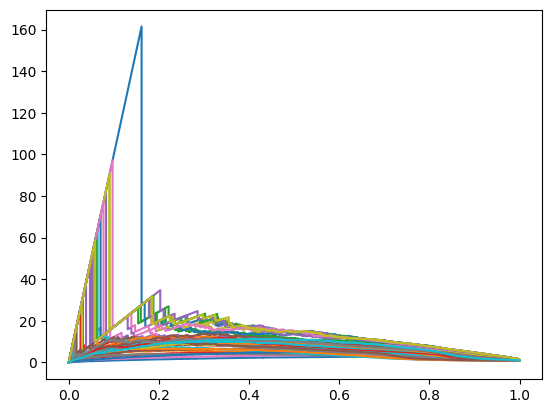

In [1027]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(3)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
    print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sig_frac*train_reference)]),len(x[m1,m2][0:int(sig_frac*train_reference)])/train_reference)
    test_list += [train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sig_frac*train_reference)]),len(x[m1,m2][0:int(sig_frac*train_reference)])/train_reference]
    
    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

model_all2.trainable_

In [ ]:
sig_list

(0.0, 700.0)

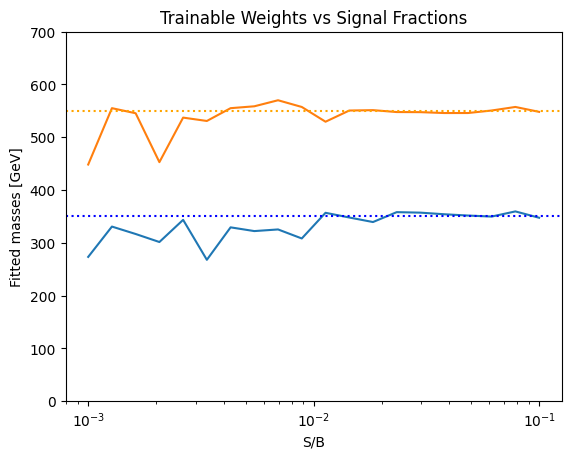

In [1028]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0.5, 1.0, 'S/B vs Fitted S/B')

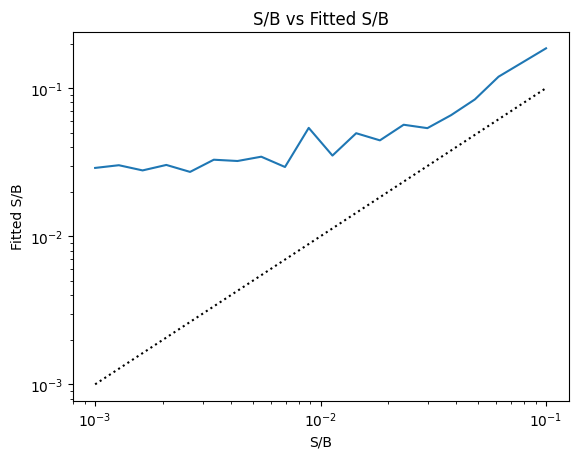

In [1029]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

Text(0, 0.5, 'max SIC')

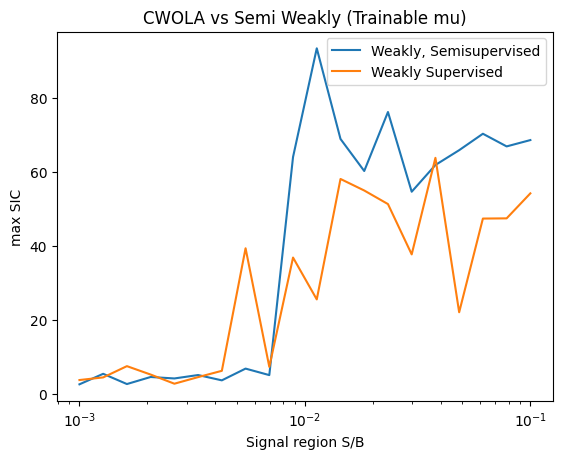

In [904]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 1s 10ms/step - loss: 0.7152 - val_loss: 0.7074
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7066 - val_loss: 0.7026
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7026 - val_loss: 0.7003
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7004 - val_loss: 0.6989
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6979
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6971
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6966
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6962
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6958
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7125 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7046 - val_loss: 0.7041
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7011 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6980 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6972 - val_loss: 0.6982
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6971
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6967
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6964
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7138 - val_loss: 0.7082
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7057 - val_loss: 0.7032
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7021 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7000 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6988 - val_loss: 0.6981
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6974
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6972 - val_loss: 0.6968
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6964
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6961
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6958
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7124 - val_loss: 0.7094
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7009 - val_loss: 0.7019
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7004
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6977 - val_loss: 0.6993
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6985
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6979
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6974
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6970
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6967
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7139 - val_loss: 0.7081
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7056 - val_loss: 0.7033
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7019 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6986 - val_loss: 0.6982
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6975
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6969
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6965
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6962
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6959
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7126 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7047 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6990
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6983
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6978
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6959 - val_loss: 0.6973
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6971
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6968
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7137 - val_loss: 0.7080
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7054 - val_loss: 0.7030
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7018 - val_loss: 0.7005
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6997 - val_loss: 0.6990
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6985 - val_loss: 0.6980
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6973
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6967
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6963
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6960
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6957
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7154 - val_loss: 0.7062
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7069 - val_loss: 0.7016
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7030 - val_loss: 0.6992
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.6979
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6994 - val_loss: 0.6970
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6977 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6956
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6953
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6950
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7122 - val_loss: 0.7088
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7042 - val_loss: 0.7037
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.7012
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.6996
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6973
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6962
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7125 - val_loss: 0.7084
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7034
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.7009
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6994
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6984
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6977
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6971
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6966
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6963
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 11ms/step - loss: 0.7111 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7035 - val_loss: 0.7040
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7002 - val_loss: 0.7013
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6997
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6973 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6972
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7103 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7028 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6997 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6962 - val_loss: 0.6981
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6970
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6949 - val_loss: 0.6966
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6963
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7128 - val_loss: 0.7066
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7019
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.6994
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6980
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6971
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6955
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6952
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6950
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7129 - val_loss: 0.7061
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7048 - val_loss: 0.7012
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.6988
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.6973
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6964
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6957
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6953
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6949
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6946
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6944
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7096 - val_loss: 0.7075
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7022 - val_loss: 0.7025
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7001
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6986
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6977
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6953 - val_loss: 0.6969
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6948 - val_loss: 0.6964
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6944 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6955
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 7s 213ms/step - loss: 0.7096 - val_loss: 0.7064
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7020 - val_loss: 0.7015
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.6991
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6976
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6947 - val_loss: 0.6956
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6943 - val_loss: 0.6952
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6949
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.6947
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7092 - val_loss: 0.7050
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.7004
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6982
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6969
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.6955
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6950
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6936 - val_loss: 0.6947
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6945
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6943
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7091 - val_loss: 0.7034
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.6987
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6966
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6953
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6945
Epoch 6/20
31/31 [==============================] - 1s 28ms/step - loss: 0.6947 - val_loss: 0.6939
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6942 - val_loss: 0.6935
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6932
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6936 - val_loss: 0.6930
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7075 - val_loss: 0.7020
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6976
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6967 - val_loss: 0.6956
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6951 - val_loss: 0.6945
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6941 - val_loss: 0.6938
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6929
Epoch 8/20
31/31 [==============================] - 1s 29ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 11ms/step - loss: 0.7049 - val_loss: 0.7009
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6966
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6947
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6936
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6923 - val_loss: 0.6929
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6918 - val_loss: 0.6924
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6914 - val_loss: 0.6921
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6912 - val_loss: 0.6919
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6910 - val_loss: 0.6917
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6908 - val_loss: 0.6916
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


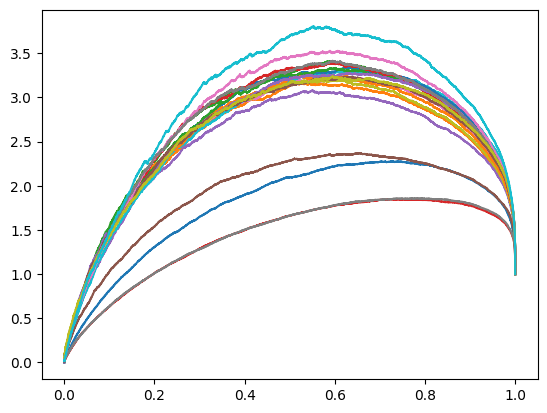

In [946]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_qq.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]